# Project: GW injection and Parameter estimation¶
Author: Tri Nguyen

In this tutorial, we will inject a gravitational-wave (GW) signal into LIGO data and perform parameter estimation on a redudced parameter space to extract the parameters of the signal. We will be utilizing the Bilby, which is a Python-based user-friendly Bayesian inference library for GW data analysis. For more information about Bilby, please visit: https://lscsoft.docs.ligo.org/bilby/ and https://arxiv.org/pdf/1811.02042.pdf. 


This notebook is based on the Bilby tutorial for GW injection and parameter estimation.

In [1]:
# Install Bilby and some of its dependency
!pip install bilby
!pip install gwpy lalsuite

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from __future__ import division, print_function

import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

import bilby
from bilby.gw.source import lal_binary_black_hole
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters

%matplotlib inline

## Gravitational-wave injection
### Example

In the example, we will inject a binary black hole (BBH) into a Gaussian noise background.

In [3]:
# Set random seed for reproducibility
np.random.seed(74656541)

In [4]:
# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
# make up some injection parameters and inject signal into data
injection_parameters = dict(
    mass_1=50, mass_2=50, a_1=0., a_2=0., tilt_1=0., tilt_2=0.,
    phi_12=0., phi_jl=0., luminosity_distance=500, theta_jn=0., psi=0.,
    phase=0.2, geocent_time=1243309096, ra=0., dec=0.)



# First, we define the duration and sampling frequency of the data segment
# that we will inject the GW signal into. For our BBH, a duration of 4 seconds 
# will be sufficient to capture the entire waveform.
duration = 4.
# We set the sampling frequency to 2048 Hz because the BBH waveform does not usually
# extend pass 1024 Hz 
sampling_frequency = 2048.

In [5]:
# LIGO approximates GW waveforms by interpolating between GW templates in a template bank
# which is generated from physical simulations (e.g. numerical relativity, post-Newtonian). 
# These waveform families are called **waveform approximant**. 
# For more information on these waveform approximants, please visit: 

# https://www.lsc-group.phys.uwm.edu/ligovirgo/cbcnote/Waveforms/Overview

# In this example, we will use the waveform approximant `IMRPhenomPv2`. 
# This is a phenomenological model that approximates the GW waveforms 
# during the three stages of an inspiral (Inspiral, Merger, Ringdown). `IMRPhenomPv2` also uses 
# a single-spin frequency-dependent post-Newtonian rotation  to describe spin precession effects.

# We define a WaveformGenerator object to generate any BBH waveform 
# given the appropriate parameters
waveform_arguments = {
    'waveform_approximant': 'IMRPhenomPv2',
    'reference_frequency': 50.,  # most sensitive frequency
    'minimum_frequency': 20.
}
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    frequency_domain_source_model=lal_binary_black_hole,
    waveform_arguments=waveform_arguments)

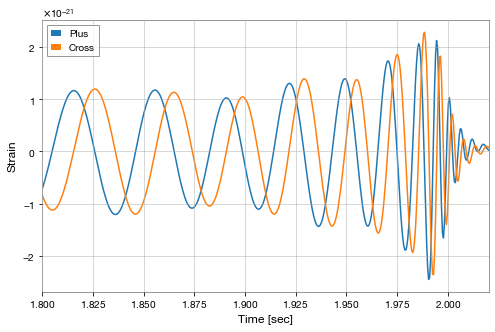

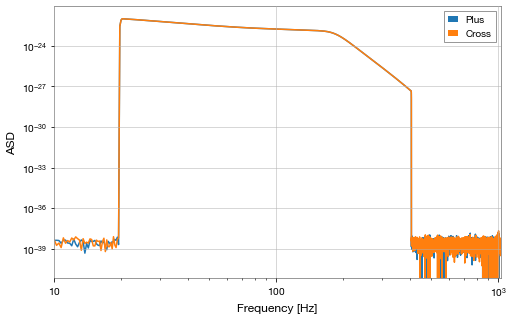

In [6]:
# We'd like to see what kind of signal we will be generating
# We examine the signal in the time domain
polarizations_td = waveform_generator.time_domain_strain(injection_parameters)
plus_td = np.roll(polarizations_td['plus'], int(sampling_frequency * 2))
cross_td = np.roll(polarizations_td['cross'], int(sampling_frequency * 2))
time = np.linspace(0., duration, len(plus_td))

fig = plt.figure(figsize=(8, 5))

plt.plot(time, plus_td, label='Plus')
plt.plot(time, cross_td, label='Cross')
plt.xlabel('Time [sec]')
plt.ylabel('Strain')
plt.xlim(1.8, 2.02)
plt.legend()
plt.show()

# And their ASD
NFFT = int(4 * sampling_frequency)
freq, plus_psd = sig.welch(plus_td, fs=sampling_frequency, nperseg=NFFT)
plus_asd = np.sqrt(plus_psd)

freq, cross_psd = sig.welch(cross_td, fs=sampling_frequency, nperseg=NFFT)
cross_asd = np.sqrt(cross_psd)

fig = plt.figure(figsize=(8, 5))
plt.loglog(freq, plus_asd, label='Plus')
plt.loglog(freq, cross_asd, label='Cross')
plt.xlim(10, 1024)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD')
plt.legend()
plt.show()

In [7]:
# For this object, we will only use LIGO Hanford (H1) and LIGO Livingston (L1)
# Because H1 and L1 have different antenna patterns (which is based on their 
# orientation and location of Earth), each will see a different GW waveform. 
# We set up Bilby Interferometer object with the GPS time around the geocenter time
# of the GW signal. By default, each interferometer will have a Gaussian noise 
# background with the PSD being their design sensitivity.
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)

# Inject GW signal into H1 and L1
polarizations = ifos.inject_signal(waveform_generator=waveform_generator,
                                   parameters=injection_parameters)

/Users/pharris/Library/Python/3.7/lib/python/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
11:13 bilby INFO    : Injected signal in H1:
11:13 bilby INFO    :   optimal SNR = 75.77
11:13 bilby INFO    :   matched filter SNR = 74.32-0.67j
11:13 bilby INFO    :   mass_1 = 50
11:13 bilby INFO    :   mass_2 = 50
11:13 bilby INFO    :   a_1 = 0.0
11:13 bilby INFO    :   a_2 = 0.0
11:13 bilby INFO    :   tilt_1 = 0.0
11:13 bilby INFO    :   tilt_2 = 0.0
11:13 bilby INFO    :   phi_12 = 0.0
11:13 bilby INFO    :   phi_jl = 0.0
11:13 bilby INFO    :   luminosity_distance = 500
11:13 bilby INFO    :   theta_jn = 0.0
11:13 bilby INFO    :   psi = 0.0
11:13 bilby INFO    :   phase = 0.2
11:13 bilby INFO    :   geocent_time = 1243309096
11:13 bilby INFO    :   ra = 0.0
11:13 bilby INFO    :   dec = 0.0
11:13 bilby INFO    : Injected signal in L

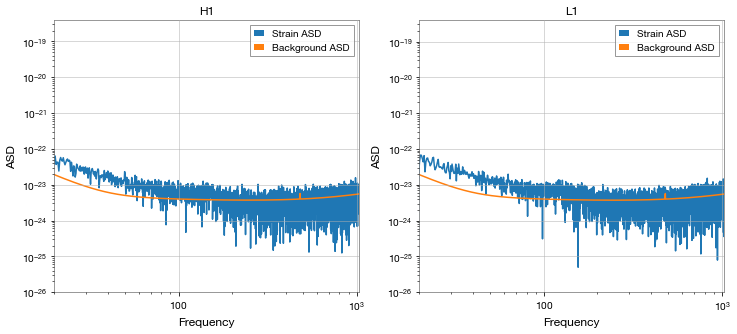

In [8]:
# We would like to visualize what the injected GW strain looks like
# First, we extract the H1 and L1 strain from the Inteferometer object
H1_strain = ifos[0].time_domain_strain
L1_strain = ifos[1].time_domain_strain

# And calculate their PSD and ASD
NFFT = int(sampling_frequency * 4)
freq, H1_strain_psd = sig.welch(H1_strain, fs=sampling_frequency, nperseg=NFFT)
H1_strain_asd = np.sqrt(H1_strain_psd)
freq, L1_strain_psd = sig.welch(L1_strain, fs=sampling_frequency, nperseg=NFFT)
L1_strain_asd = np.sqrt(L1_strain_psd)

# We also like to extract the background PSD and ASD
H1_bg_psd = ifos[0].power_spectral_density.psd_array
H1_bg_asd = np.sqrt(H1_bg_psd)
L1_bg_psd = ifos[1].power_spectral_density.psd_array
L1_bg_asd = np.sqrt(L1_bg_psd)
freq_bg = ifos[0].power_spectral_density.frequency_array

# We plot the strain ASD on top of the background ASD
# Because we inject a loud signal (H1 optimal SNR = 73.24, L1 optimal SNR = 79.75)
# we should be able to see the signal
fig = plt.figure(figsize=(12, 5))

# Plot H1 strain and background ASD
ax1 = plt.subplot(121)
ax1.loglog(freq, H1_strain_asd, label='Strain ASD')
ax1.loglog(freq_bg, H1_bg_asd, label='Background ASD')
ax1.set_title('H1')
ax1.set_xlim(20, 1024)
ax1.set_ylim(1e-26, None)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('ASD')
ax1.legend()

# Plot L1 strain and background ASD
ax2 = plt.subplot(122)
ax2.loglog(freq, L1_strain_asd, label='Strain ASD')
ax2.loglog(freq_bg, L1_bg_asd, label='Background ASD')
ax2.set_title('L1')
ax2.set_xlim(20, 1024)
ax2.set_ylim(1e-26, None)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('ASD')
ax2.legend()

plt.show()

### Student work

Now it is your time to shine. Inject a BBH with the following parameters into a Gaussian noise background:

- Masses $M_1$ and $M_2$: 36 $M_\odot$ and 29 $M_\odot$
- Dimensionless spin magnitudes $a_1$ and $a_2$: 0.4 and 0.3
- Difference between the azimuthal angles of the individual spin vector projections onto the orbital plane $\phi_{12}$: 97.4 $\deg$
- Difference between total and orbital angular momentum azimuthal angles $\phi_{jl}$: 17.2 $\deg$
- Tilt angle between their spins and the orbital angular momentum $\theta_1$ and $\theta_2$: 28.6 $\deg$ and 57.3 $\deg$
- Luminosity distance $D_L$: 2000 Mpc
- Inclination angle: $\theta_{jn}$: 22.9 $\deg$
- Polarisation angle $\psi$: 152.3 $\deg$
- Phase at coalescence $\phi_c$: 74.5 $\deg$
- Sky position RA and DEC: 78.8 $\deg$ and -69.4$\deg$
- Geocentric time: GPS 1126259642.413

You should use the same signal duration, sampling frequency, and waveform approximant as above. You do **not** have to reproduce the plots.

In [9]:
%reset -f

In [10]:
from __future__ import division, print_function

import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

import bilby
from bilby.gw.source import lal_binary_black_hole
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters

%matplotlib inline

In [11]:
# Set random seed for reproducibility
np.random.seed(74656541)

### -------------------START-CODE-------------------- ###
# Set up injection parameters and other time series parameters
injection_parameters = dict(
    mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=2000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)
duration = 4.
sampling_frequency = 2048.

# Set up waveform generator
waveform_arguments = {
    'waveform_approximant': 'IMRPhenomPv2',
    'reference_frequency': 50.,
    'minimum_frequency': 20.
}
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    frequency_domain_source_model=lal_binary_black_hole,
    waveform_arguments=waveform_arguments)

# Set up interferometer
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
polarizations = ifos.inject_signal(waveform_generator=waveform_generator,
                                   parameters=injection_parameters)
### -------------------END-CODE-------------------- ###

/Users/pharris/Library/Python/3.7/lib/python/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
11:13 bilby INFO    : Injected signal in H1:
11:13 bilby INFO    :   optimal SNR = 12.03
11:13 bilby INFO    :   matched filter SNR = 12.20+0.60j
11:13 bilby INFO    :   mass_1 = 36.0
11:13 bilby INFO    :   mass_2 = 29.0
11:13 bilby INFO    :   a_1 = 0.4
11:13 bilby INFO    :   a_2 = 0.3
11:13 bilby INFO    :   tilt_1 = 0.5
11:13 bilby INFO    :   tilt_2 = 1.0
11:13 bilby INFO    :   phi_12 = 1.7
11:13 bilby INFO    :   phi_jl = 0.3
11:13 bilby INFO    :   luminosity_distance = 2000.0
11:13 bilby INFO    :   theta_jn = 0.4
11:13 bilby INFO    :   psi = 2.659
11:13 bilby INFO    :   phase = 1.3
11:13 bilby INFO    :   geocent_time = 1126259642.413
11:13 bilby INFO    :   ra = 1.375
11:13 bilby INFO    :   dec = -1.2108
11:13 bilby INFO    : I

## Parameter estimation

We are now ready to extract the parameters of this GW signal from the Gaussian noise background. Our goal is to find the posterior distribution. However, because the posterior distribution is often intractable, LIGO uses posterior sampling algorithm (such as MCMC and Nested Sampling) to evaluate the posterior distribution. We will cover MCMC later in the course.


To begin sampling the posterior distribution, we need to define the prior distribution and likelihood distribution (Remember Bayes' rule?). We will first set up the prior distribution. Bilby uses a dictionary class structure to store the prior of each GW parameters. Each prior distribution can be defined with a Bilby class object. For more information about prior dictionary in Bilby, please visit: https://lscsoft.docs.ligo.org/bilby/prior.html.

Below is an example prior used to extract the parameters of the first BBH GW150914.

In [12]:
example_priors = bilby.gw.prior.BBHPriorDict(filename='GW150914.prior')
example_priors

{'mass_ratio': Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary='reflective'),
 'chirp_mass': Uniform(minimum=25, maximum=31, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary='reflective'),
 'mass_1': Constraint(minimum=10, maximum=80, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=10, maximum=80, name='mass_2', latex_label='$m_2$', unit=None),
 'a_1': Uniform(minimum=0, maximum=0.99, name='a_1', latex_label='$a_1$', unit=None, boundary='reflective'),
 'a_2': Uniform(minimum=0, maximum=0.99, name='a_2', latex_label='$a_2$', unit=None, boundary='reflective'),
 'tilt_1': Sine(name='tilt_1', latex_label='$\\theta_1$', unit=None, minimum=0, maximum=3.141592653589793, boundary='reflective'),
 'tilt_2': Sine(name='tilt_2', latex_label='$\\theta_2$', unit=None, minimum=0, maximum=3.141592653589793, boundary='reflective'),
 'phi_12': Uniform(minimum=0, maximum=6.283185307179586, name='phi_12

Now, you will create your own prior dictionary. By default, LIGO samples all 15 GW parameters (Can you name them all?). However, because this can take up to several days, we will instead work with a 2-dimensional space. Specifically, you will only sample the chirp mass $M_c$ and mass ratio $q$ of the BBH (see note). Feel free to play around with different type of priors.

You might find these Bilby classes useful:
- `bilby.prior.Uniform`
- `bilby.prior.Gaussian`
- `bilby.prior.DeltaFunction`
- ...

NOTE 1: We usually sample the chirp mass and mass ratio instead of the component masses $M_{1,2}$ because they tend to help the sampler converge faster and more easily. 

NOTE 2: You will have to define priors for the parameters that you are **not** sampling (e.g. $a_{1,2}$, $D_L$, etc.). If you don't, Bilby will use their default prior, and you will spend **a lot** of time sampling. Assume that we already know the values for these parameters, what kind of distribution should their priors be?

In [13]:
priors = {}

### -------------------START-CODE-------------------- ###
priors['mass_ratio'] = bilby.prior.Uniform(0.7, 1., name='mass_ratio')
priors['chirp_mass'] = bilby.prior.Uniform(20, 40, name='chirp_mass')
priors['a_1'] = bilby.prior.DeltaFunction(0.4, name='a_1')
priors['a_2'] = bilby.prior.DeltaFunction(0.3, name='a_2')
priors['tilt_1'] = bilby.prior.DeltaFunction(0.5, name='tilt_1')
priors['tilt_2'] = bilby.prior.DeltaFunction(1.0, name='tilt_2')
priors['phi_12'] = bilby.prior.DeltaFunction(1.7, name='phi_12')
priors['phi_jl'] = bilby.prior.DeltaFunction(0.3, name='phi_jl')
priors['theta_jn'] = bilby.prior.DeltaFunction(0.4, name='theta_jn')
priors['psi'] = bilby.prior.DeltaFunction(2.659, name='psi')
priors['phase'] = bilby.prior.DeltaFunction(1.3, name='phase')
priors['luminosity_distance'] = bilby.prior.DeltaFunction(2000., name='luminosity_distance')
priors['geocent_time'] = bilby.prior.DeltaFunction(1126259642.413, name='geocent_time')
priors['ra'] = bilby.prior.DeltaFunction(1.375, name='ra')
priors['dec'] = bilby.prior.DeltaFunction(-1.2108, name='dec')
### -------------------END-CODE-------------------- ###

priors

{'mass_ratio': Uniform(minimum=0.7, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chirp_mass': Uniform(minimum=20, maximum=40, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.4, name='a_1', latex_label='$a_1$', unit=None),
 'a_2': DeltaFunction(peak=0.3, name='a_2', latex_label='$a_2$', unit=None),
 'tilt_1': DeltaFunction(peak=0.5, name='tilt_1', latex_label='$\\theta_1$', unit=None),
 'tilt_2': DeltaFunction(peak=1.0, name='tilt_2', latex_label='$\\theta_2$', unit=None),
 'phi_12': DeltaFunction(peak=1.7, name='phi_12', latex_label='$\\Delta\\phi$', unit=None),
 'phi_jl': DeltaFunction(peak=0.3, name='phi_jl', latex_label='$\\phi_{JL}$', unit=None),
 'theta_jn': DeltaFunction(peak=0.4, name='theta_jn', latex_label='$\\theta_{JN}$', unit=None),
 'psi': DeltaFunction(peak=2.659, name='psi', latex_label='$\\psi$', unit=None),
 'phase': DeltaFunction(peak=1.3, name='phase', latex_label='$\\phi$', u

Now, we will set up a Gaussian noise likelihood function. Writing the likelihood can be a bit complicate, so we will use `bilby.gw.GravitationalWaveTransient` function from Bilby. However, it is important that you understand where this function , so we'll ask you to write its equation down.  

You can find your answer in this paper: https://arxiv.org/pdf/1809.02293.pdf (Hint: check the appendix)

#### Answer:
Remember to explain all your variables.
\begin{equation}
    \mathcal{L(d|\theta)} = 
\end{equation}
where $d$ is the GW strain and $\theta$ is a set of GW parameters.

In [14]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator)

11:14 bilby WARNING : The waveform_generator start_time is not equal to that of the provided interferometers. Overwriting the waveform_generator.


Once we define the prior and likelihood distribution, we will use Bilby to sample the posterior distribution.

For this example, we will use the `dynesty` sampler, which Dynamic Nested Sampling package for estimating Bayesian posteriors and evidences. For more information about `dynesty`, please visit: https://dynesty.readthedocs.io/en/latest/.

In [15]:
outdir = 'GW_PEInjection_result'
label = '2_parameters'
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=1000, 
    resume=True, outdir=outdir, label=label)

11:14 bilby INFO    : Running for label '2_parameters', output will be saved to 'GW_PEInjection_result'
11:14 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.66;Id: 04a60e3ac9b6ecb285cf96d1137c6a62a3d5cfde;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
11:14 bilby INFO    : Search parameters:
11:14 bilby INFO    :   mass_ratio = Uniform(minimum=0.7, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
11:14 bilby INFO    :   chirp_mass = Uniform(minimum=20, maximum=40, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
11:14 bilby INFO    :   a_1 = 0.4
11:14 bilby INFO    :   a_2 = 0.3
11:14 bilby INFO    :   tilt_1 = 0.5
11:14 bilby INFO    :   tilt_2 = 1.0
11:14 bilby INFO    :   phi_12 = 1.7
11:14 bilby INFO    :   phi_jl = 0.3
11:14 bilby INFO    :   theta_jn = 0.4
11:14 bilby INFO    :   psi = 2.659
11:14 bilby INFO    :   phase = 1.3
11:14 bilby INFO    :   luminosity_distance = 2000.

0it [00:00, ?it/s]

11:14 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12cda3810>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
11:14 bilby INFO    : Checkpoint every n_check_point = 200000
11:14 bilby INFO    : Using dynesty version 1.0.1
11:14 bilby INFO    : Using the bilby-implemented rwalk sample 

7264it [14:43,  4.19it/s, bound:594 nc:101 ncall:401039 eff:1.8% logz-ratio=115.81+/-0.11 dlogz:1.577>0.10] 

11:29 bilby INFO    : Writing checkpoint file GW_PEInjection_result/2_parameters_resume.pickle



9773it [24:12,  4.44it/s, bound:1013 nc:101 ncall:654449 eff:1.5% logz-ratio=116.90+/-0.11 dlogz:0.100>0.10]

11:38 bilby INFO    : Writing checkpoint file GW_PEInjection_result/2_parameters_resume.pickle



9773it [24:13,  6.72it/s, bound:1013 nc:1 ncall:654449 eff:1.6% logz-ratio=117.00+/-0.11 dlogz:0.000>0.10]  



11:38 bilby INFO    : Sampling time: 0:24:09.819802
11:38 bilby INFO    : Summary of results:
nsamples: 10773
ln_noise_evidence: -8228.297
ln_evidence: -8111.298 +/-  0.113
ln_bayes_factor: 116.999 +/-  0.113



Last but not least, let's show your sampling result by making a beautiful plot. The most common way to show a multi-dimensional posterior distribution is to use a corner plot. Plotting a corner plot manually can be tricky, so we strongly recommend you to use the `corner` package (https://corner.readthedocs.io/en/latest/). However, feel free to use any plotting tool you are accustomed to.

In this exercise, please plot the corner plot of the two component masses $M_1$ and $M_2$ of the BBH. Note that these are **not** the same parameters you have been sampling (which are chirp mass and mass ratio), so you will to convert your samples. You might find the chirp mass $M_c$ and mass ratio $q$ expressions below useful:

\begin{equation}
M_c = \frac{(M_1 M_2)^{3/5}}{(M_1 + M_2)^{1/5}}\; \text{and} \; q=\frac{M_2}{M_1}
\end{equation}

What are the final values of the component masses $M_1$, $M_2$ of the BBH? Please include error bars and any neccessary statistics. How are these values compared to the true injection values?

In [16]:
# First, we want to extract the posterior samples from bilby.result
samples = result.posterior[['chirp_mass', 'mass_ratio']].values

### -------------------START-CODE-------------------- ###

import corner

# Calculate mass 1 and mass 2 from chirp mass and mass ratio
chirp_mass = samples[:, 0]
mass_ratio = samples[:, 1]
total_mass  = chirp_mass * (1 + mass_ratio) ** 1.2 / mass_ratio ** 0.6
mass_1= total_mass / (1 + mass_ratio)
mass_2= total_mass - mass_1

# Add to samples array
samples[:, 0] = mass_1
samples[:, 1] = mass_2

# Add true parameters
truths = (injection_parameters['mass_1'], injection_parameters['mass_2'])

# Plot corner plot
fig = plt.figure(figsize=(8, 8))
fig = corner.corner(
    samples, truths=truths, labels=(r'$M_1$', r'$M_2$'), 
    quantiles=(0.16, 0.84), levels=(0.9, ), bins=20, fig=fig,
    color='k', truth_color='r', show_titles=True, title_kwargs={"fontsize": 12})

### -------------------END-CODE-------------------- ###

ValueError: Provided figure has 0 axes, but data has dimensions K=2

<Figure size 576x576 with 0 Axes>

#### Answer:
The final values of the component masses $M_1$, $M_2$ of the BBH are:
\begin{equation}
M_1 = 36.15^{+0.36}_{-0.37} M_\odot \;\text{and}\; M_2 = 28.91^{+0.16}_{-0.15} M_\odot
\end{equation}

## Conclusion

Congratulations! You have reached the end of the tutorial. Parameter estimation is a tough problem in gravitational-wave physics (and many other areas of physics) due to the intractable nature of the posterior distribution. Posterior sampling algorithms, such as MCMC and Nested Sampling, help solve this problem at a cost of long run-time. This makes it difficult to perform electromagnetic follow-up of time-sensitive GW sources like binary neutron stars. 

Deep learning algorithms are currently being developed to accelerate the posterior sampling process:

- https://arxiv.org/abs/2010.12931
- https://arxiv.org/abs/2002.07656
- https://arxiv.org/abs/2008.03312
- ...